Having regrown the network after significant pruning, and found a somewhat lower cost, 
train with asymmetry parameter 10.0 rather than 2.5 so the efficiency and false positive rate can be measured.

Use RunModel_IntervalTracks_to_hists_25August2023_HDplusUNet100_regrow_after_pruning as the template for this notebook.

-------------------------------


Having pruned both FC weights and UNet channels, start with the pruned models, but allow
all weights, including those set to zero during pruning, to float again.  The goal is to
determine whether the cost functions (training and validation) will drop even lower.

The pruning was done in

`RunModel_IntervalTracks_to_hists_22August2023_HDplusUNet100_CNNpruning01_epochs-1em4`

We will start with learning_rate = 2e-5 as this is the value used for the final re-training
after pruning.


------------------------------

August 22:  derived from 

  RunModel_IntervalTracks_to_hists_19August2023_HDplusUNet100_CNNpruning00_10_epochs-1em4
  
which pruned a total of 16 channels of rcbn1[0] weights (in two passes of 8 channels each)
from the U-Net part of the model.  A prior notebook removed half of the layer2, layer3, layer4,
layer5, and layer6A FC weights.  To get started here, it will be necessary to "prune" all the
removed weight again so they are not "re-learned".  For the FC layer weights, l1-pruning the
requisite number of weights will work as these have weight=0.  For the U-Net channels, the
notebook will need to explicitly prune those previously removed:

  to_remove =  [45 24 46 13 36 37 30 48  2  5 59 51 52 47 21 29]
  
  
The code will look similar to

```
importance = torch.ones((64,8,25))
print("importance.shape = ",importance.shape)
for ii in more_to_remove:
    importance[ii,:,:] = 0
    
importance.to(device)
prune.l1_unstructured(model.rcbn1[0], name="weight", amount=len(more_to_remove)*n_in*kernel_size,importance_scores=importance)
```

but using `to_remove` rather than `more_to_remove`

Here is a first plan for this notebook:

* First, make sure to re-prune the pruned weights.
* Increase the batch-size from 256 to 512 to see if this works/decreases time per epoch
* Concurrently, increase the learning rate from 1e-4 to 5e-4 as the training costs were dropping essentially montonical during retraining.

* Begin to prune more U-Net weights and re-train, probably starting with the second U-Net layer (rcbn2[0].

   ----->>
   
   Starting to execute the notebook, the layer1 weights look OK, but the layer2, layer3, layer 4,
   layer5, and layer6A weights look like they have bee re-initialized to random values; very odd
   see cell [18]
   
   It looks like the preceding notebook has
   
   ```prune.remove(model.rcbn1[0],'weight')```
   
   but left the pruned version of the weights in the FC layer in the .pyt file
   
Problem fixed by using an update_dict with "original" weights from input file.  This is an ugly solution.  Going forward, all notebooks should prune previously pruned weights at the beginning and explicitly 1remove1 them at the end.


-------------------------------------------
-------------------------------------------





start from RunModel_IntervalTracks_to_hists_09August2023_HDplusUNet100_pruning02_300_more_epochs-1em4 which pruned 50% of the fully-connected layer2, layer3, layer4, layer5, and layer6A weights.

in this notebook we want to prune weights from the UNet part of the model (the CNN layers).

see

  https://towardsdatascience.com/how-to-prune-neural-networks-with-pytorch-ebef60316b91
  
for reference


--------------

start pruning02 from the pruning01 stored weights. These followed 5 iterations of pruning 5% and re-training.
add code to save the pruned weights after each iteration and "smooth out" the number of epochs to make them more equal.

potential issue -- as the final weights were save after prune.remove, there is probably no "memory" that 25% of the weights in layers 2, 3, 4, 5, and 6A have already been set tozero.  If so, then it will probably be necessary 
to "prune" 30% of the weights to remove these zeros plus the next smallest-valued 5% of the weights.

-----------------------------------------------------

start pruning01 from iter8Ca % remove 5% of weights from layers 2, 3, 4, 5, and 6 based on Sara's observations that these do not degrade the tracks-to-KDE model performance.

----------------------------------------------------

start iter8Ca from iter7Ca and continue for another 125 epochs; same batch size, same learning rate

----------------------------------------------

start iter7Ca where iter^Ca left off, increasing the batch size from 138 to 256 and increasing the number of epochs from 5 to 25.

---------------------------------

iter6Ca created from iter6C; the only differences are the batch size (increasing from 64 to 128), changing gpu(2) to gpu(0), and changing the name of the file where results are stored.

-------------------

iter6C created 07-August-2023 picks up where 

RunModel_IntervalTracks_to_hists_11September2022_HDplusUNet100_iter5C-alt_lossAA-10epochs-1em4_fullLHCbMC-scrubbed_data_float_all_weights

left off.

Its primary purpose is to make sure it still executes as expected, this time running on sneezy. Need to change Kernel to run on sneezy rather than sleepy.

Assuming this works as expected, the next iterations will attempt pruning plus re-training some of the fully connected layers, based on how well this works for the tracks-to-KDE model.

----------------------------------------------



iter5C will pick up where iter4C did "best" (lowest validation cost, near lowest training cost), epoch #7, with with 1e-4 learning rate rather than 1e-3.  A few epochs later, the costs jumped enormously, indicating the weights escaped from the vicinity of a local minimum.

NB:  observed after execution -- the name that was supposed to be "pretrained_dict = " was "oretrained_dict = ", so this really started from the previous iteration, i.e., from iter3C rather than from inter4C.

--------------------------------------------------------

iter4C starts with weights from iter3C and simply continues.  NB:  iter2C ended with training cost about the same as that at the beginning of iter1C; so floating all the weights seems to have increased confusion for a bit; it finished with training cost about where iter1C started;  am hopeful the extra capacity (and more epochs) of this notebook will lead to an even better result.

------------------------------------------------------- 

iter3C starts with weights from iter2C and lets all weights float during learning.

---------------------------------------------------



iter2C starts with the weights from iter1C (weights from from 6 fully connected layers remain frozen) and replace 

  from model.interval_kde_loss_Ba import Loss
  
 with
 
   from model.alt_loss_AA import Loss
   
and use

  loss = Loss(epsilon=1e-5,coefficient=2.5)

Presumably, the subsequent iteration will be run with all weights floated to see what effect that has.
 
 
-------------------------------

iter0C tries to learn tracks_to_hists starting with weights from tracks_to_KDE learning with fully connected layer weights and biases frozen; iter1C continues for another 20 epochs where iter0C left off (weights from from 6 fully connected layers remain frozen as the overall cost remains high).

-----------------------------------


From RunModel_IntervalTracks_to_KDE_27Aug2022_HDplusUNet100_iter1A-testing-50epochs-1em4_fullLHCbMC-scrubbed_data.ipynb, derive

RunModel_IntervalTracks_to_hists_10September2022_HDplusUNet100_iter0B-testing-5epochs-1em4_fullLHCbMC-scrubbed_data

This will read in tracks_to_hists Array datasets rather than tracks_to_KDE data sets that have not been "prepared".

Also, the loss function will be changed to a standard for for target histogram learning.

It will initially use weights from the IntervalTracks_to_KDE learning.  For this variation on the theme (iter0B compared to inter0A), let's freeze the weights from the fully connected layers at the front end.


---------------------------

Derive iter4A from iter#A.  Mostimportant changes -- used "scrubbed" data files in which events with
problematic KDEs have been removed and use 250 tracks per event rather than 150 as the long tail
creates some high-cost intervals.

Derive iter3A from iter2A; NB that collect_t2kde_data in in collectdata_kde_Ellipsoids_aug2022.py has (this morning) been modified to store only kernel info as labels, not xMax or Ymax info

----------------------------------

Derive iter2A from iter1A: RunModel_IntervalTracks_to_KDE_17Aug2022_HalfDozen_iter1A-testing-50epochs-2em5_fullLHCbMC 


Derive iter1 from iter0; start wherre iter0 left off and comment out code tht resets biases when starting


------------------------------
 
 

This is a copy of 

  RunModel_IntervalTracks_to_KDE_08Aug2022_HalfDozen_iter0-testing-50epochs-1em4_repeat
  
modified to use full LHCb MC rather than toy MC.  This requires changing the train_loader and val_loader input file and using a version of collectdata that "scrubs" the poca_ellipsoid data

 -------------------------------------------------

basically, a copy  of 

  RunModel_IntervalTracks_to_KDE_15July_HalfDozen_iter0-testing-50epochs-1em4

to see if those results are reproducible.  The only two changes are

   (i)  use gpu(2) rather than gpu(0)
   (ii) for val_loader, use slice=xxx

In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in note"book, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT


In [2]:
import numpy as np
##  testing the np.floor and np.int_ methods as they seem to fail in a method used below
##  from model.collectdata_kde_Ellipsoids_29Aug2021 import collect_t2kde_data
print("np.version.version = ",np.version.version)
a = np.array([-1.7, -1.5, -0.2, 0.2, 1.5, 1.7, 2.0])
aFloor = np.floor(a)
print("a = ",a)
print("a.shape = ",a.shape)
print("aFloor = ",aFloor)
print("aFloor.shape = ",aFloor.shape)
aFloorInt = np.int_(aFloor)
print("aFloorInt = ",aFloorInt)

np.version.version =  1.21.1
a =  [-1.7 -1.5 -0.2  0.2  1.5  1.7  2. ]
a.shape =  (7,)
aFloor =  [-2. -2. -1.  0.  1.  1.  2.]
aFloor.shape =  (7,)
aFloorInt =  [-2 -2 -1  0  1  1  2]


This notebook is the second (perhaps third) attempt to read in track information and use it to predict the KDE used as input to pv-finder. This time, we are reading in poca KDEs rather than the original KDEs. 

collectdata_kde_Ellipsoids.py uses poca_z, poca_x, poca_y, and six parameters A, B, C, D, E, and F describing the error ellipsoids are those defined at

from https://math.stackexchange.com/questions/1865188/how-to-prove-the-parallel-projection-of-an-ellipsoid-is-an-ellipse

Up to translation, a general ellipsoid can be written in the form

  𝐴$𝑥^2$ +𝐵$𝑦^2$+𝐶$𝑧^2$+2(𝐷𝑥𝑦+𝐸𝑥𝑧+𝐹𝑦𝑧)=1
  
for some positive-definite coefficient matrix 

$$
\left(\begin{array}{ccc}
A & D & E \\
D & B & F \\
E & F & C \\
\end{array}\right)
$$

Note that other conventions use a similarly named set of parameters with D, E, and and F denoting the coefficients of different combinations of $ x y $, etc., or without the factor of 2 in front of the cross-terms.  However, this is the convention we are using for pv-finder related work, as of early November, 20020


Check the current GPU usage. Please try to be nice!

In [3]:
!nvidia-smi

Thu Aug 31 16:20:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-PCIE-40GB      On   | 00000000:01:00.0 Off |                    0 |
| N/A   40C    P0   127W / 250W |   2570MiB / 40536MiB |     45%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  A100-PCIE-40GB      On   | 00000000:25:00.0 Off |                    0 |
| N/A   

In [4]:
import torch
print(torch.__version__)
print(torch.cuda)

1.10.1+cu111
<module 'torch.cuda' from '/data/home/sokoloff/.local/lib/python3.8/site-packages/torch/cuda/__init__.py'>


> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

This notebook is first attempt to read in track information and use it to predict the KDE used as input to PvFinder.


## Imports

In [5]:
import matplotlib.pyplot as plt
import numpy as np
print("numpy.version.version = ",np.version.version)
import time
import torch
import pandas as pd

import torch.nn.utils.prune as prune

# Python 3 standard library
from pathlib import Path

##from torchsummary import summary

numpy.version.version =  1.21.1


### Set up local parameters

In [6]:
n_epochs = 25  ## to get started

# Name is the output file name


##  201019  mds
folder = '31Aug2023_t2hists_HDplusUNet100_10p0'
name   = folder

# Make an output folder named "name" (change if you want)

## Special instructions for those working on goofy at UC
## Please be very careful to make sure that your folder
## does not live in a subdirectory of your home directory
## this disk has very little capacity. Instead, use 
## a subdirectory in /share/lazy with a symbolic link to
## it in this (the notebooks) subdirectory
folder = 'ML/' + folder
output = Path(folder)

## batch_size = 64 seems to use 20 GB on 3090,
## so set batch_size = 16 so we can run on a 2080Ti
##  batch_size 16 still seems to require commenting out
##  device=device, and one epoch takes >900 seconds
##  compared to 120 seconds with batch_size = 64 on 3090
##  so try batch_size = 64 again
#   Size of batches
## batch_size = 256
batch_size = 512
# How fast to learn
##learning_rate = 1e-4
learning_rate = 2e-5

Make the output directory if it does not exist:

In [7]:
output.mkdir(exist_ok=True)

## Get the helper functions

Add the directory with the model
definitions to the path so we can import from it:

> When you type `import X`,
Python searches `sys.path` for a python
file named `X.py` to import. So we need to add the model directory to the path.

In [8]:
from model.collectdata_kde_Ellipsoids_MinBiasMagDown_14Nov import collect_t2kde_data as collect_t2kde_data_down
from model.collectdata_kde_Ellipsoids_MinBiasMagUp_14Nov import collect_t2kde_data as collect_t2kde_data_up
## the next line brings in a new method to read in "prepared" data
from model.collectdata_kde_Ellipsoids_Arrays import collect_t2kde_arrays

## 220714 mds 
## interval_kde_loss_Ba is derived from kde_loss_Ba, modified for 100-bin intervals
## looks like it returns average loss per bin, so costs may be directly
## comparable to original DirtyDozen
##from model.interval_kde_loss_Ba import Loss
from model.alt_loss_AA import Loss

##  TracksToKDE_Ellipsoids_SevenLayerCake has 7 hidden layers producing the 4000-bin KDE historgram
##  It takes 9 input features (pocca centers + (A,B,C,D,E,F) . 
##from model.models_July2022_kde import TrackIntervalsToKDE_HalfDozen as Model
from model.models_July2022_kde_plus import TrackIntervalsToKDE_HDplusUNet100 as Model


from model.training_kde import trainNet, select_gpu, Results
from model.plots import dual_train_plots, replace_in_ax

In [9]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [10]:
##device = "cuda"
device = select_gpu(1)
##device = "cpu"

1 available GPUs (initially using device 0):
  0 A100-PCIE-40GB


## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [11]:
##print("Let's use", torch.cuda.device_count(), "GPUs!")
##if torch.cuda.device_count() > 1:
##    model = torch.nn.DataParallel(model)

In [12]:
## a comment on the web at https://pytorch.org/docs/stable/optim.html says
"""
If you need to move a model to GPU via .cuda(), please do so before constructing optimizers for it. 
Parameters of a model after .cuda() will be different objects with those before the call.

In general, you should make sure that optimized parameters live in consistent locations when 
optimizers are constructed and used.
"""
## so move this here (although we are using model.to(device) not explicitly using .cuda()

nOut1 = 20
nOut2 = 20
nOut3 = 20
nOut4 = 20
nOut5 = 20

latentChannels = 8
nUNetChannels= 64

model = Model(nOut1,nOut2,nOut3,nOut4,nOut5,latentChannels=latentChannels,n=nUNetChannels)

##summary(model, input_size=(4, 4000))
##print(model.parameters)

## add the following code to allow the user to freeze the some of the weights corresponding 
## to those taken from an earlier model trained with the original target histograms
## presumably -- this leaves either the perturbative filter "fixed" and lets the 
## learning focus on the non-perturbative features, so get started faster, or vice versa
ct = 0
for child in model.children():
  print('ct, child = ',ct, "  ", child)
  if ct < 0:
    print("     About to set param.requires_grad=False for ct = ", ct, "params")
    for param in child.parameters():
        param.requires_grad = False 
  ct += 1
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
##  loss = Loss(epsilon=1e-5,coefficient=2.5)
##loss = Loss(epsilon=3e-6, debug=False)
##loss = Loss(epsilon=3e-6)
loss = Loss(epsilon=1e-5,coefficient=10.0)

ct, child =  0    Linear(in_features=9, out_features=20, bias=True)
ct, child =  1    Linear(in_features=20, out_features=20, bias=True)
ct, child =  2    Linear(in_features=20, out_features=20, bias=True)
ct, child =  3    Linear(in_features=20, out_features=20, bias=True)
ct, child =  4    Linear(in_features=20, out_features=20, bias=True)
ct, child =  5    Linear(in_features=20, out_features=800, bias=True)
ct, child =  6    ConvBNrelu(
  (0): Conv1d(8, 64, kernel_size=(25,), stride=(1,), padding=(12,))
  (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.25, inplace=False)
)
ct, child =  7    ConvBNrelu(
  (0): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(3,))
  (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.25, inplace=False)
)
ct, child =  8    ConvBNrelu(
  (0): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (1): Batch

Let's move the model's weight matricies to the GPU:

In [13]:
model = model.to(device)

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
##optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [15]:
print('output = ',output)
##print('oldOutput = ',oldOutput)
##  use the first four layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113

##   ML -> /share/lazy/sokoloff/ML
model_dict = model.state_dict()
## mds 190725 for debugging
print("for model_dict")
index = 0
for k,v in model_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
##    print("value = ", v)
 
updated_dict = model_dict
##print("updated_dict = ",updated_dict)
## when starting "ab initio", reduce biases as the bias gets summed for each track
## contributing to the predicted KDE
##updated_dict["layer1.bias"] = 0.005*model_dict["layer1.bias"]
##updated_dict["layer2.bias"] = 0.005*model_dict["layer2.bias"]
##updated_dict["layer3.bias"] = 0.005*model_dict["layer3.bias"]
##updated_dict["layer4.bias"] = 0.005*model_dict["layer4.bias"]
##updated_dict["layer5.bias"] = 0.005*model_dict["layer5.bias"]

model.load_state_dict(updated_dict,strict=False)

model_dict = model.state_dict()

output =  ML/31Aug2023_t2hists_HDplusUNet100_10p0
for model_dict
index, k =   0    layer1.weight
index, k =   1    layer1.bias
index, k =   2    layer2.weight
index, k =   3    layer2.bias
index, k =   4    layer3.weight
index, k =   5    layer3.bias
index, k =   6    layer4.weight
index, k =   7    layer4.bias
index, k =   8    layer5.weight
index, k =   9    layer5.bias
index, k =   10    layer6A.weight
index, k =   11    layer6A.bias
index, k =   12    rcbn1.0.weight
index, k =   13    rcbn1.0.bias
index, k =   14    rcbn1.1.weight
index, k =   15    rcbn1.1.bias
index, k =   16    rcbn1.1.running_mean
index, k =   17    rcbn1.1.running_var
index, k =   18    rcbn1.1.num_batches_tracked
index, k =   19    rcbn2.0.weight
index, k =   20    rcbn2.0.bias
index, k =   21    rcbn2.1.weight
index, k =   22    rcbn2.1.bias
index, k =   23    rcbn2.1.running_mean
index, k =   24    rcbn2.1.running_var
index, k =   25    rcbn2.1.num_batches_tracked
index, k =   26    rcbn3.0.weight
index, k 

In [16]:

##print("updated model_dict = ",model_dict)

## print(" \n","  for pretrained_dict")
## index = 0
##for k,v in pretrained_dict.items():
##    print("index, k =  ",index,"  ",k)
##    index = index+1
## mds  

##pretrained_dict = torch.load('ML/29July2020_Trks_to_KDE_C_lossB_100epochs_b64_1m3_nOut_50x50/29July2020_Trks_to_KDE_C_lossB_100epochs_b64_1m3_nOut_50x50_final.pyt')
##print("model_dict instantiated")
# 1. filter out unnecessary keys
##pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
##print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
##model_dict.update(pretrained_dict) 
##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

##model.load_state_dict(pretrained_dict,strict=False)

## print('model_dict =    ', model_dict)


##pretrained_dict = torch.load('ML/27October_testing_DirtyDozen_first_learning_iter0_250epochs_1em3/27October_testing_DirtyDozen_first_learning_iter0_250epochs_1em3_220.pyt')

##  the next model had fluctuations near the end, but the final epoch is within striking distance of the lowest cost
##pretrained_dict = torch.load('ML/10September_t2hists_HDplusUNet100_iter0C_5epochs_1em3_fullLHCbMC_scrubbedData/10September_t2hists_HDplusUNet100_iter0C_5epochs_1em3_fullLHCbMC_scrubbedData_final.pyt')
##pretrained_dict = torch.load('ML/10September_t2hists_HDplusUNet100_iter1C_5epochs_20em3_fullLHCbMC_scrubbedData/10September_t2hists_HDplusUNet100_iter1C_5epochs_20em3_fullLHCbMC_scrubbedData_final.pyt')
pretrained_dict = torch.load('ML/10September_t2hists_HDplusUNet100_iter3C_10epochs_1em3_fullLHCbMC_scrubbedData/10September_t2hists_HDplusUNet100_iter3C_10epochs_1em3_fullLHCbMC_scrubbedData_final.pyt')
pretrained_dict = torch.load('ML/25Aug2023_t2hists_HDplusUNet100_regrowth00/25Aug2023_t2hists_HDplusUNet100_regrowth00_524.pyt')
print(" ")
print("  for pretrained_dict")
index = 0
for k,v in pretrained_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
 

# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
model_dict.update(pretrained_dict)



#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

##model.load_state_dict(pretrained_dict,strict=False)
model.load_state_dict(pretrained_dict,strict=True)


 
  for pretrained_dict
index, k =   0    layer1.weight
index, k =   1    layer1.bias
index, k =   2    layer2.weight
index, k =   3    layer2.bias
index, k =   4    layer3.weight
index, k =   5    layer3.bias
index, k =   6    layer4.weight
index, k =   7    layer4.bias
index, k =   8    layer5.weight
index, k =   9    layer5.bias
index, k =   10    layer6A.weight
index, k =   11    layer6A.bias
index, k =   12    rcbn1.0.weight
index, k =   13    rcbn1.0.bias
index, k =   14    rcbn1.1.weight
index, k =   15    rcbn1.1.bias
index, k =   16    rcbn1.1.running_mean
index, k =   17    rcbn1.1.running_var
index, k =   18    rcbn1.1.num_batches_tracked
index, k =   19    rcbn2.0.weight
index, k =   20    rcbn2.0.bias
index, k =   21    rcbn2.1.weight
index, k =   22    rcbn2.1.bias
index, k =   23    rcbn2.1.running_mean
index, k =   24    rcbn2.1.running_var
index, k =   25    rcbn2.1.num_batches_tracked
index, k =   26    rcbn3.0.weight
index, k =   27    rcbn3.0.bias
index, k =   28   

<All keys matched successfully>

##print('validation.dataset.tensors = ',validation.dataset.tensors)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

In [17]:
## Training dataset. You can put as many files here as desired.

## Training dataset. You can put as many files here as desired.

##train_loader = collect_t2kde_data('/share/lazy/pv-finder/20k_evts_for_KDE_learning_200716.h5',
train_loader = collect_t2kde_arrays('dataAA/pv_HLT1CPU_MinBiasMagUp_14Nov_t2hists_Arrays.npy',                                 
                            batch_size=batch_size,
                            pin_memory=True,
##                            device=device,
                           )

##train_loader_B = collect_t2kde_arrays('dataAA/pv_HLT1CPU_MinBiasMagDown_14Nov_t2kdeA_Arrays_training.npy',                                  
##                            batch_size=batch_size,
##                            pin_memory=True,
##                            device=device,
##                           )
                            

# Validation dataset. You can slice to reduce the size.
## mds no separate validation set yet,
val_loader = collect_t2kde_arrays('dataAA/pv_HLT1CPU_MinBiasMagDown_14Nov_t2hists_Arrays_validation.npy',
                            batch_size=batch_size,
                            pin_memory=True,
## 220715 running out of CUDA memory when device=device enabled,
## so comment out to see if this helps
##                          device=device,
                           )

XY_file =  dataAA/pv_HLT1CPU_MinBiasMagUp_14Nov_t2hists_Arrays.npy
Loaded dataAA/pv_HLT1CPU_MinBiasMagUp_14Nov_t2hists_Arrays.npy in 1.709 s
outer loop X.shape =  (2053960, 9, 120)
Constructing 2053960 event dataset took 0.4638 s
x_t.shape =  torch.Size([2053960, 9, 120])
x_t.shape[0] =  2053960
x_t.shape[1] =  9
y_t.shape =  torch.Size([2053960, 100])
XY_file =  dataAA/pv_HLT1CPU_MinBiasMagDown_14Nov_t2hists_Arrays_validation.npy
Loaded dataAA/pv_HLT1CPU_MinBiasMagDown_14Nov_t2hists_Arrays_validation.npy in 0.3819 s
outer loop X.shape =  (452560, 9, 120)
Constructing 452560 event dataset took 0.1097 s
x_t.shape =  torch.Size([452560, 9, 120])
x_t.shape[0] =  452560
x_t.shape[1] =  9
y_t.shape =  torch.Size([452560, 100])


model =  TrackIntervalsToKDE_HDplusUNet100(
  (layer1): Linear(in_features=9, out_features=20, bias=True)
  (layer2): Linear(in_features=20, out_features=20, bias=True)
  (layer3): Linear(in_features=20, out_features=20, bias=True)
  (layer4): Linear(in_features=20, out_features=20, bias=True)
  (layer5): Linear(in_features=20, out_features=20, bias=True)
  (layer6A): Linear(in_features=20, out_features=800, bias=True)
  (rcbn1): ConvBNrelu(
    (0): Conv1d(8, 64, kernel_size=(25,), stride=(1,), padding=(12,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.25, inplace=False)
  )
  (rcbn2): ConvBNrelu(
    (0): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(3,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.25, inplace=False)
  )
  (rcbn3): ConvBNrelu(
    (0): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  

<IPython.core.display.Javascript object>


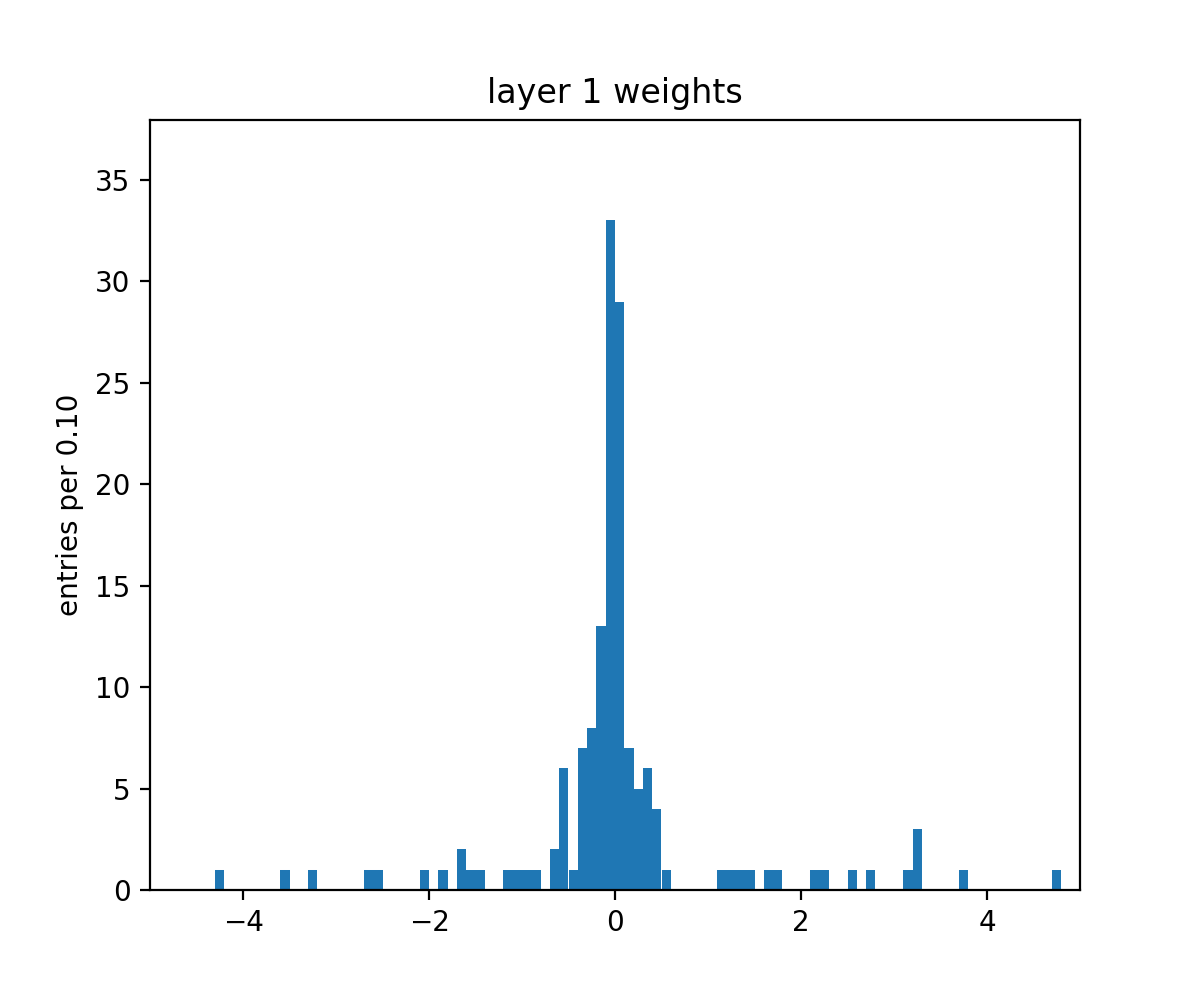

<IPython.core.display.Javascript object>


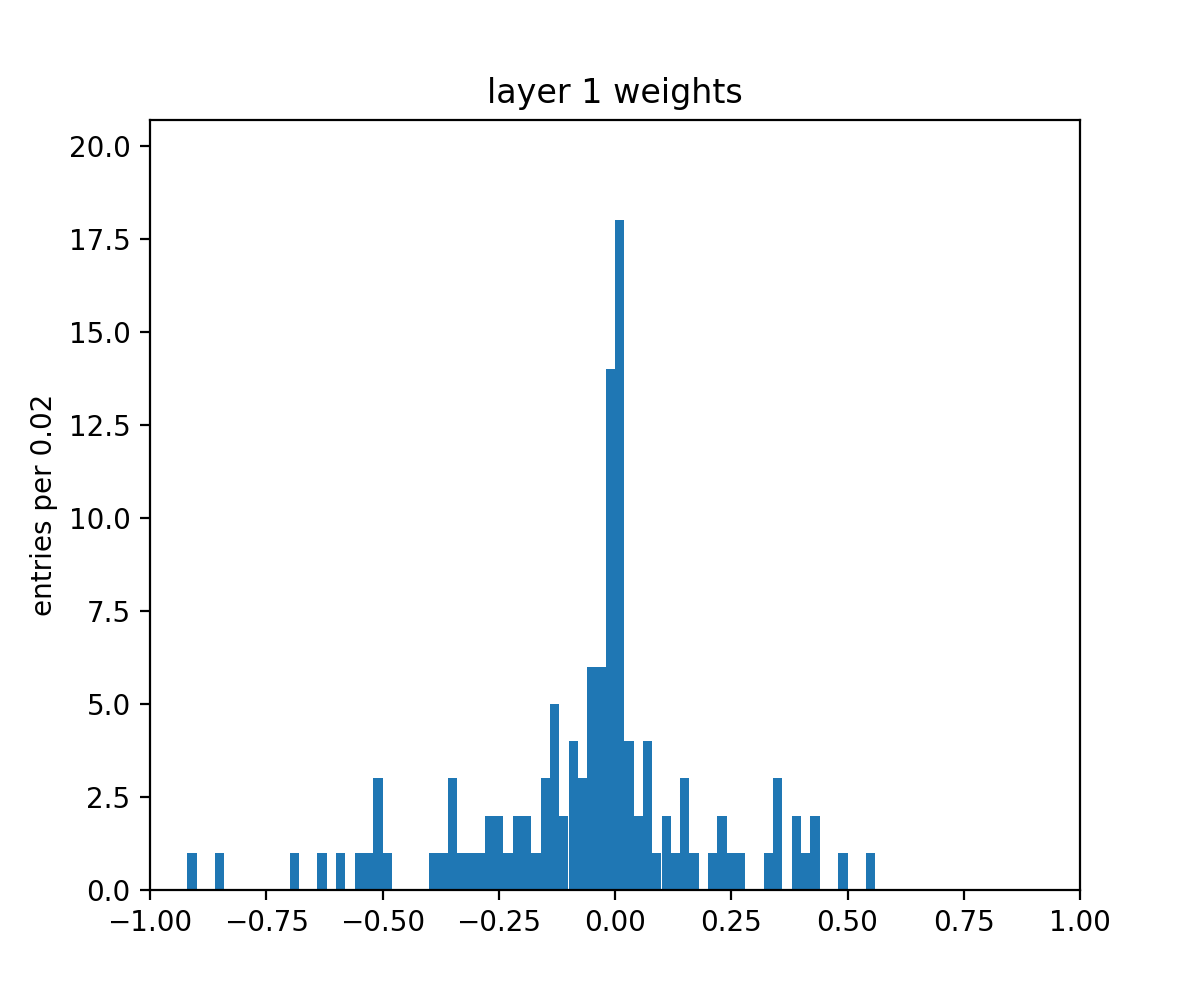

<IPython.core.display.Javascript object>


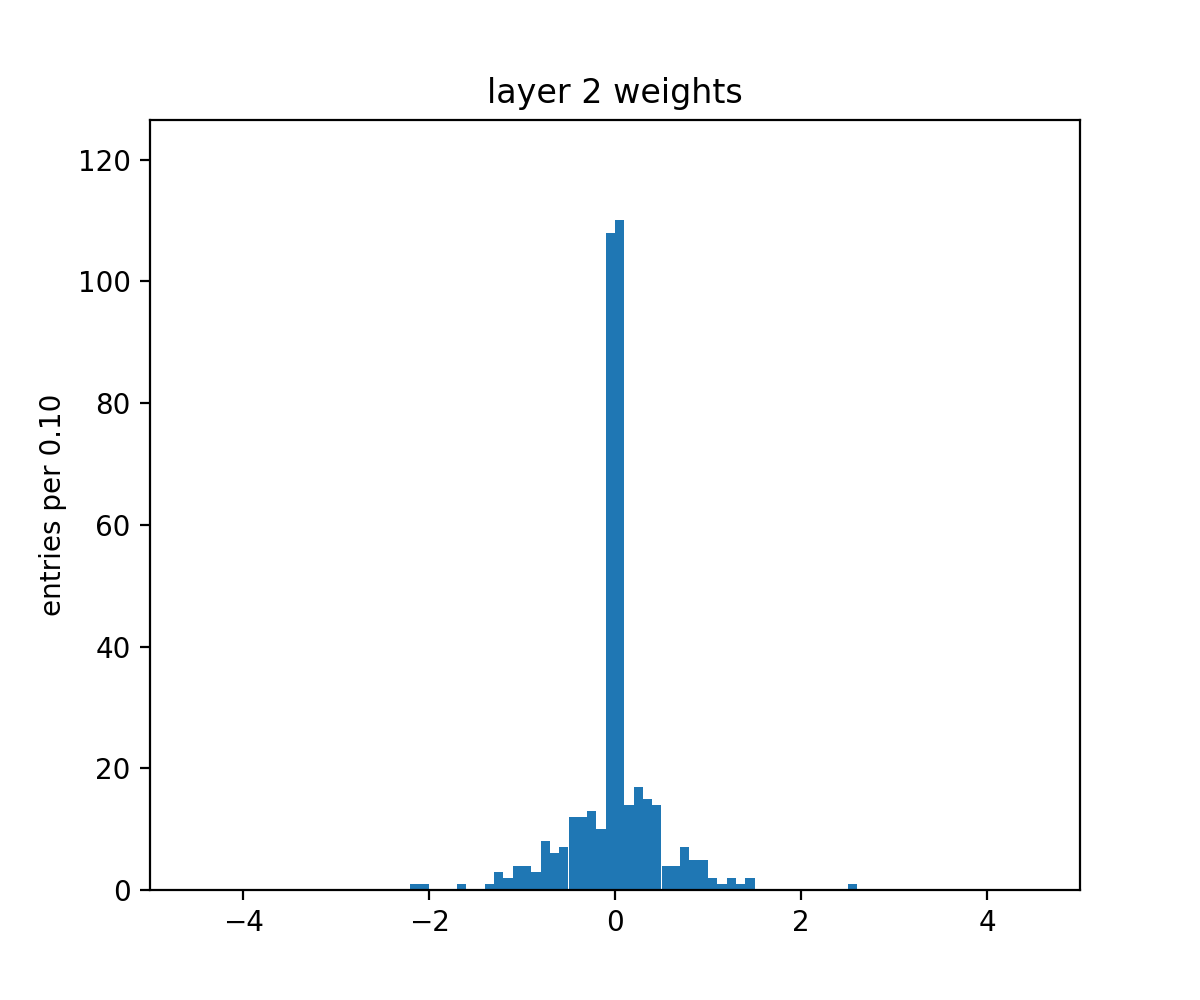

<IPython.core.display.Javascript object>


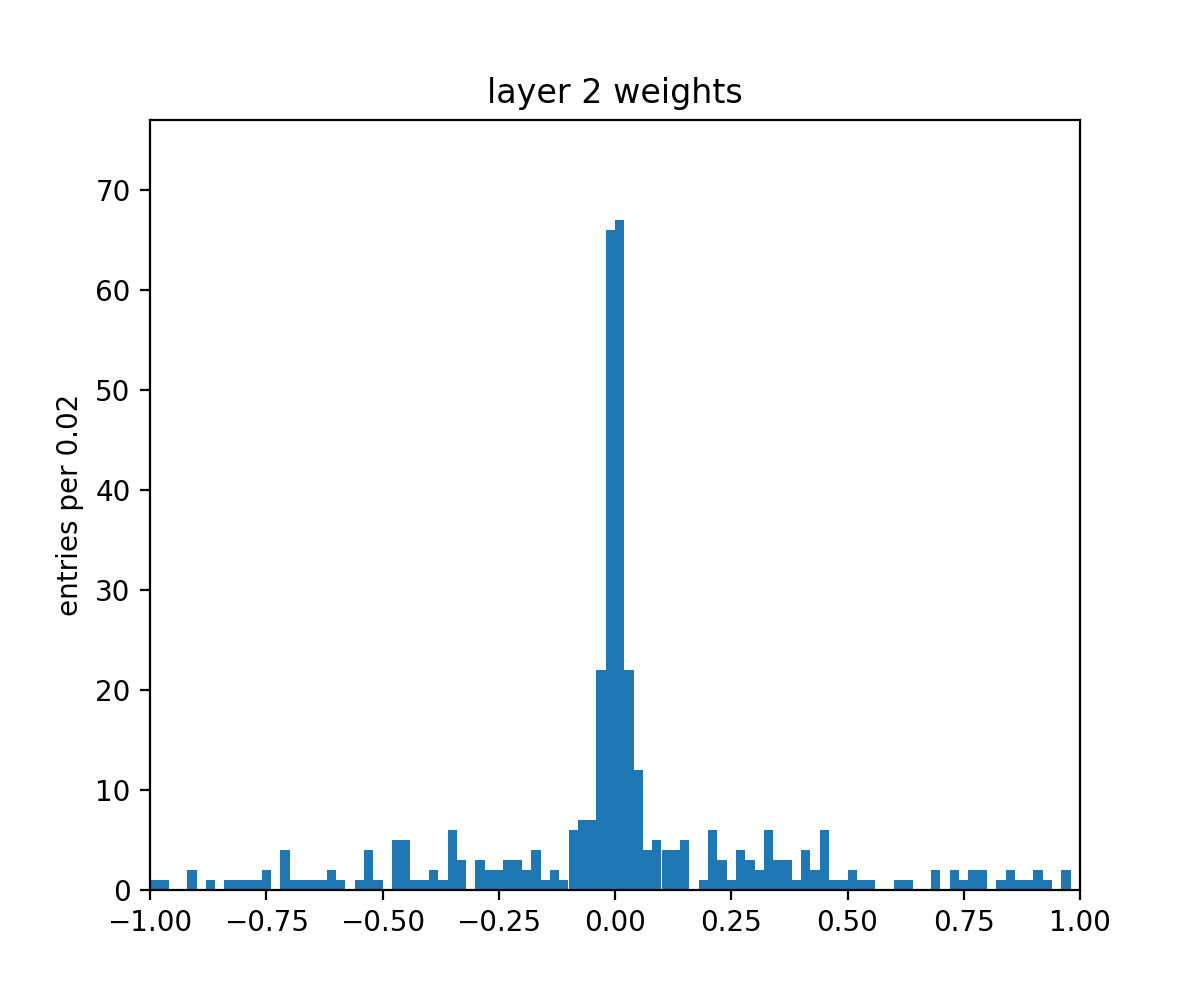

<IPython.core.display.Javascript object>


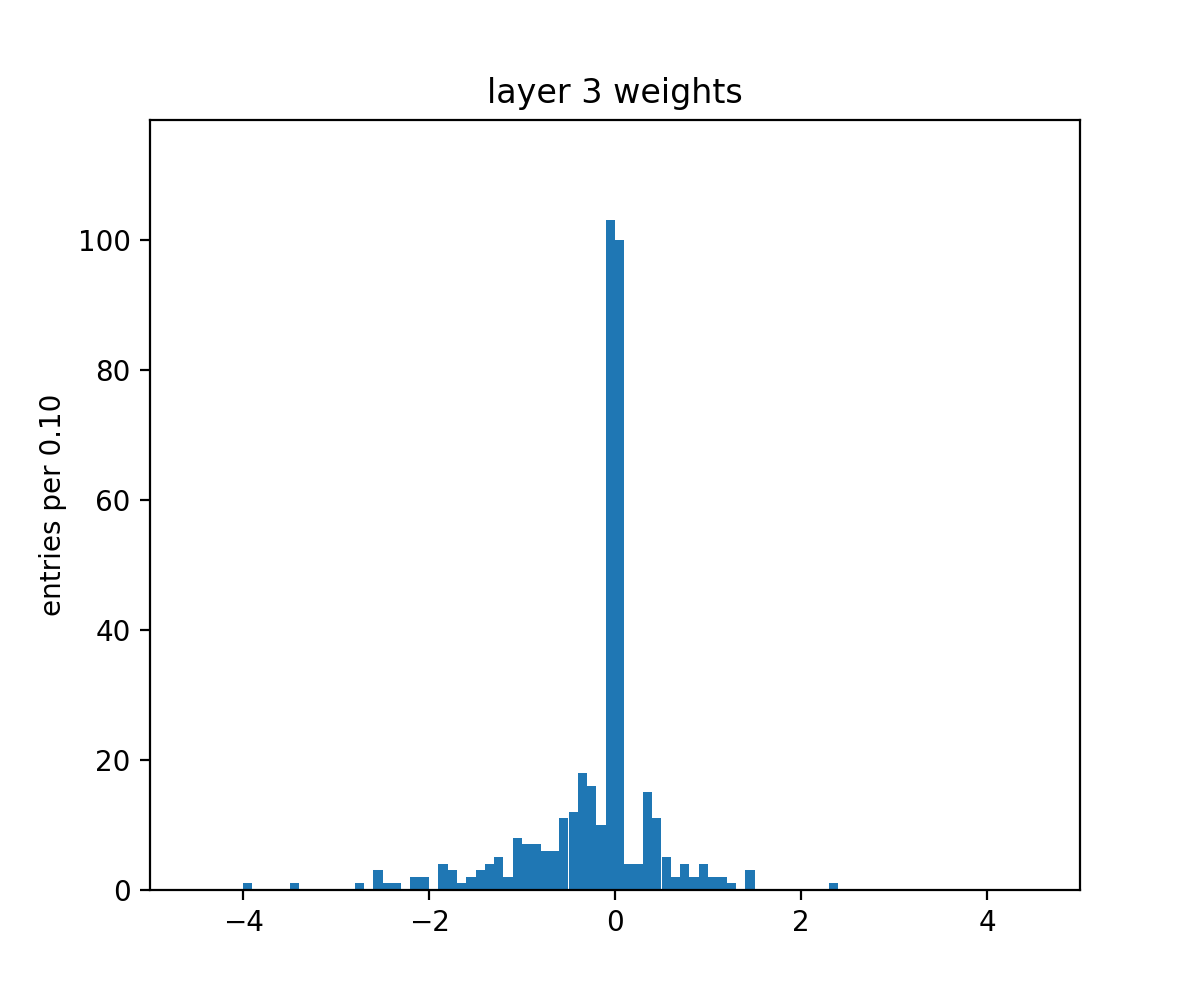

<IPython.core.display.Javascript object>


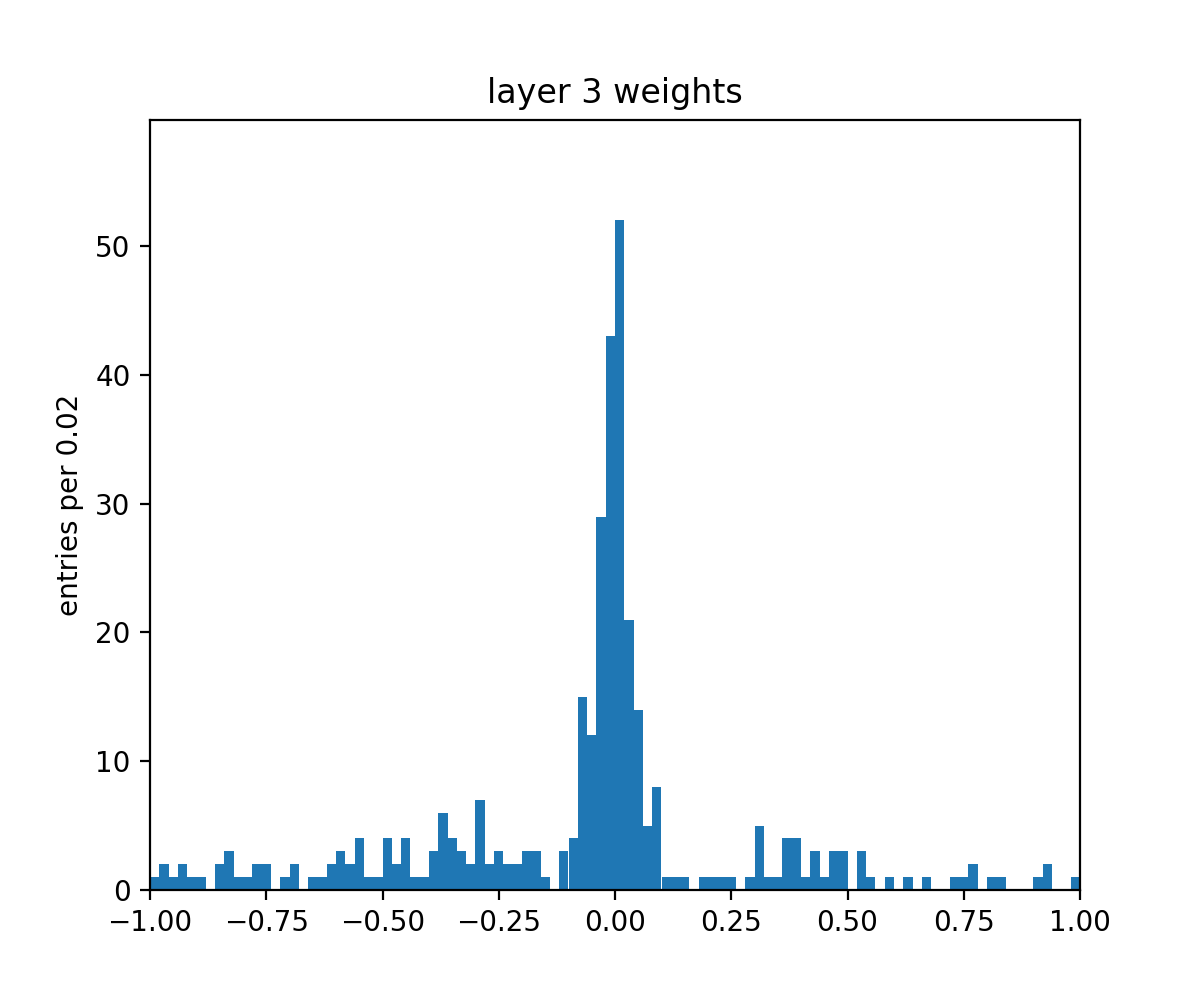

<IPython.core.display.Javascript object>


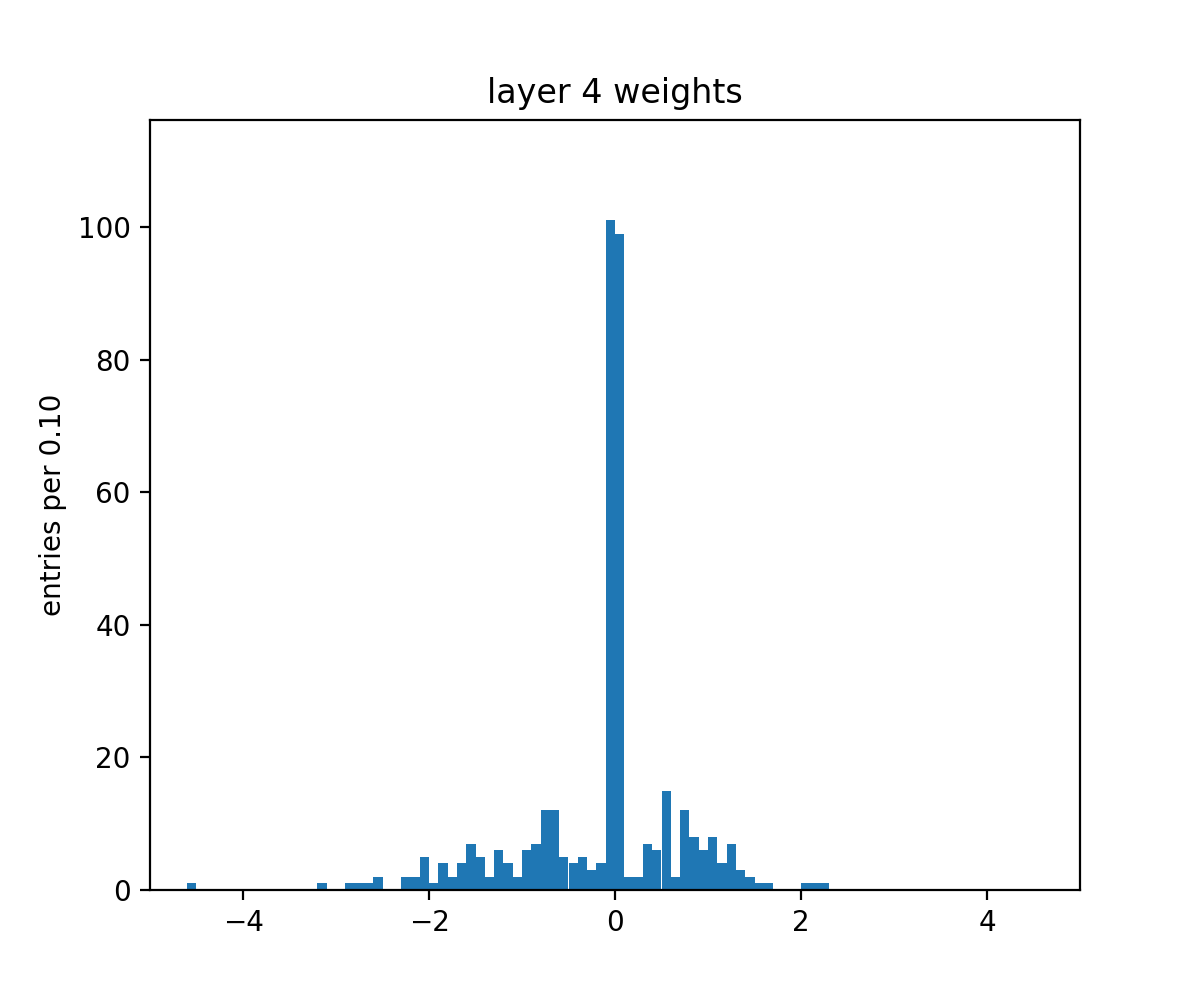

<IPython.core.display.Javascript object>


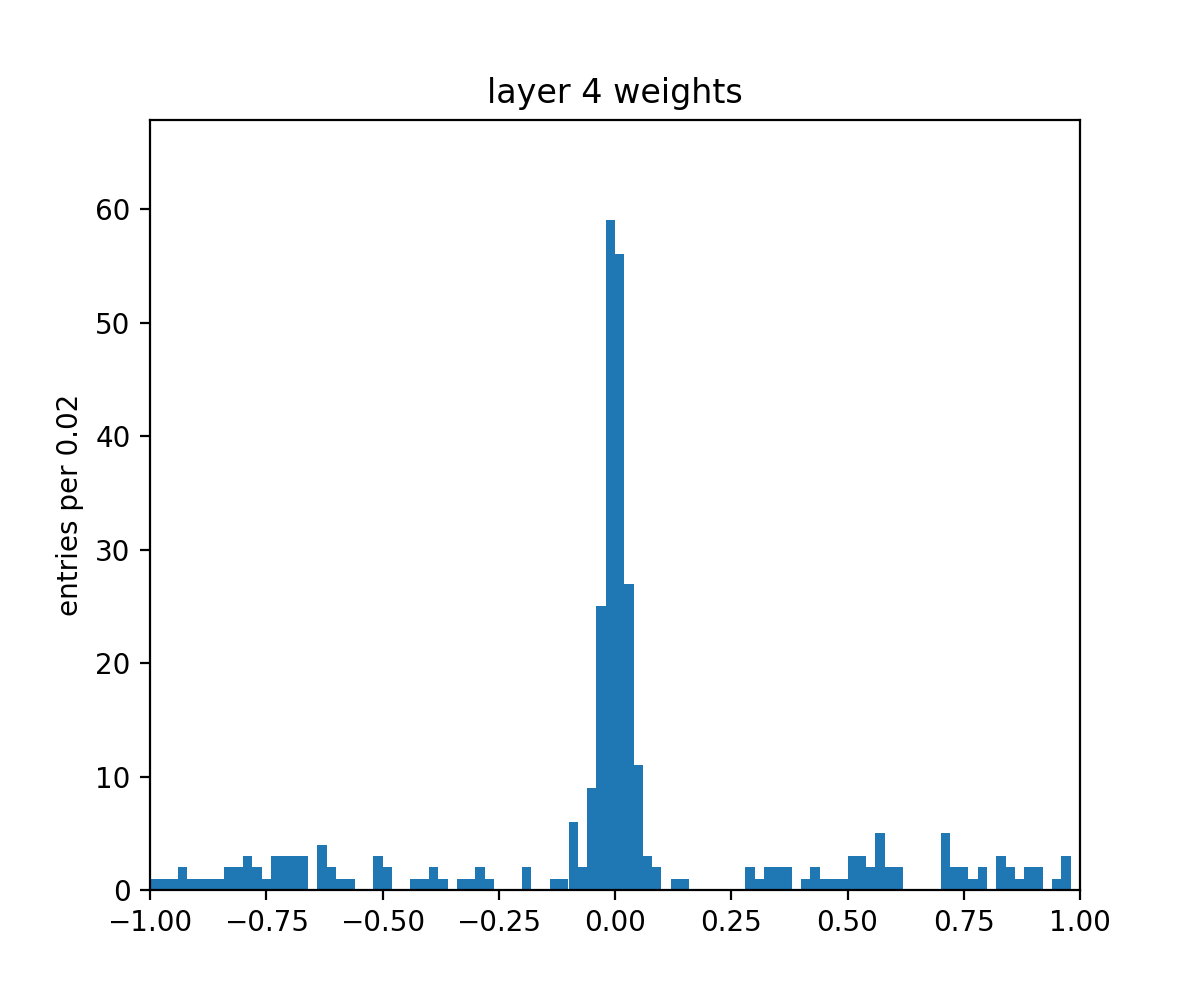

<IPython.core.display.Javascript object>


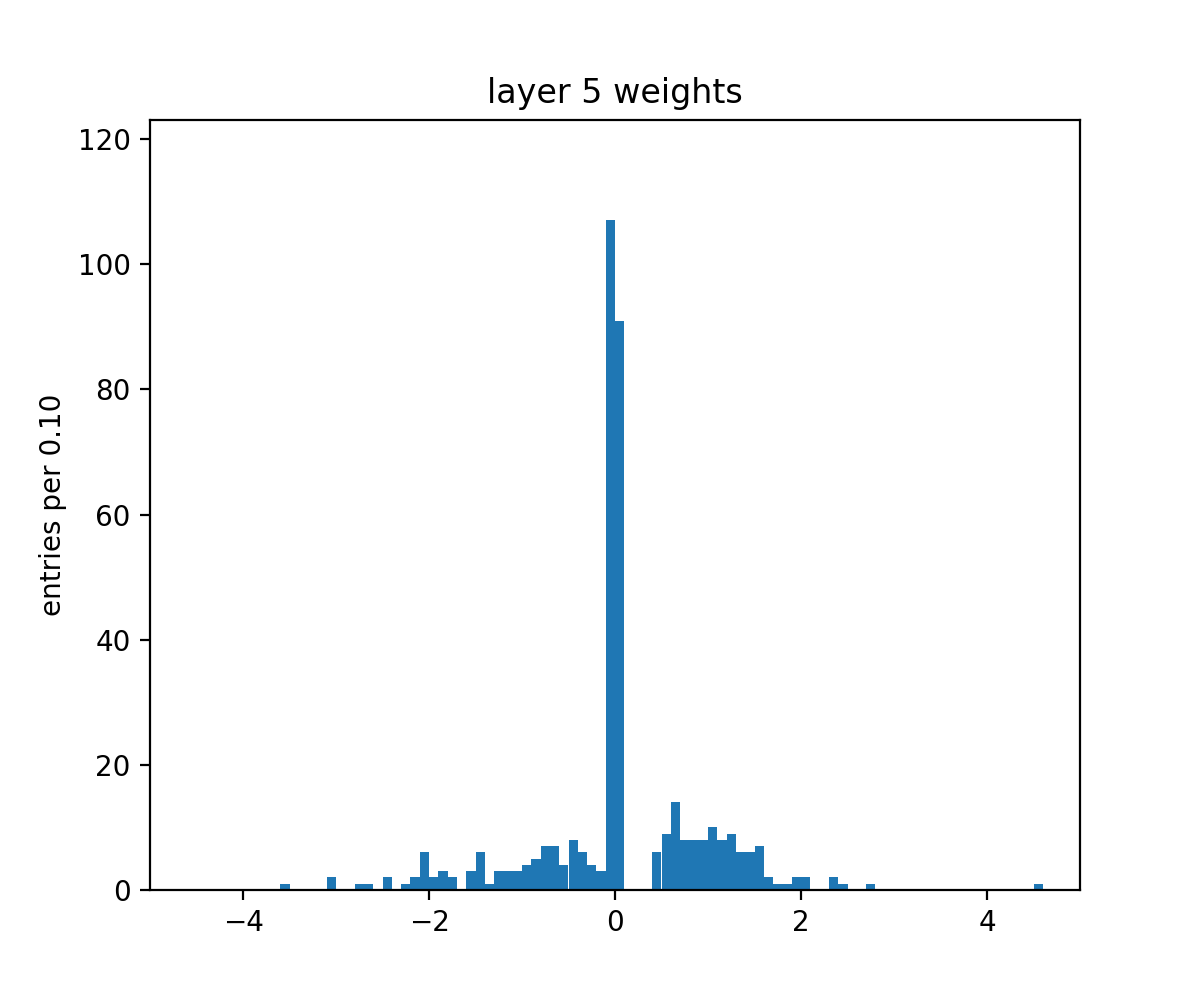

<IPython.core.display.Javascript object>


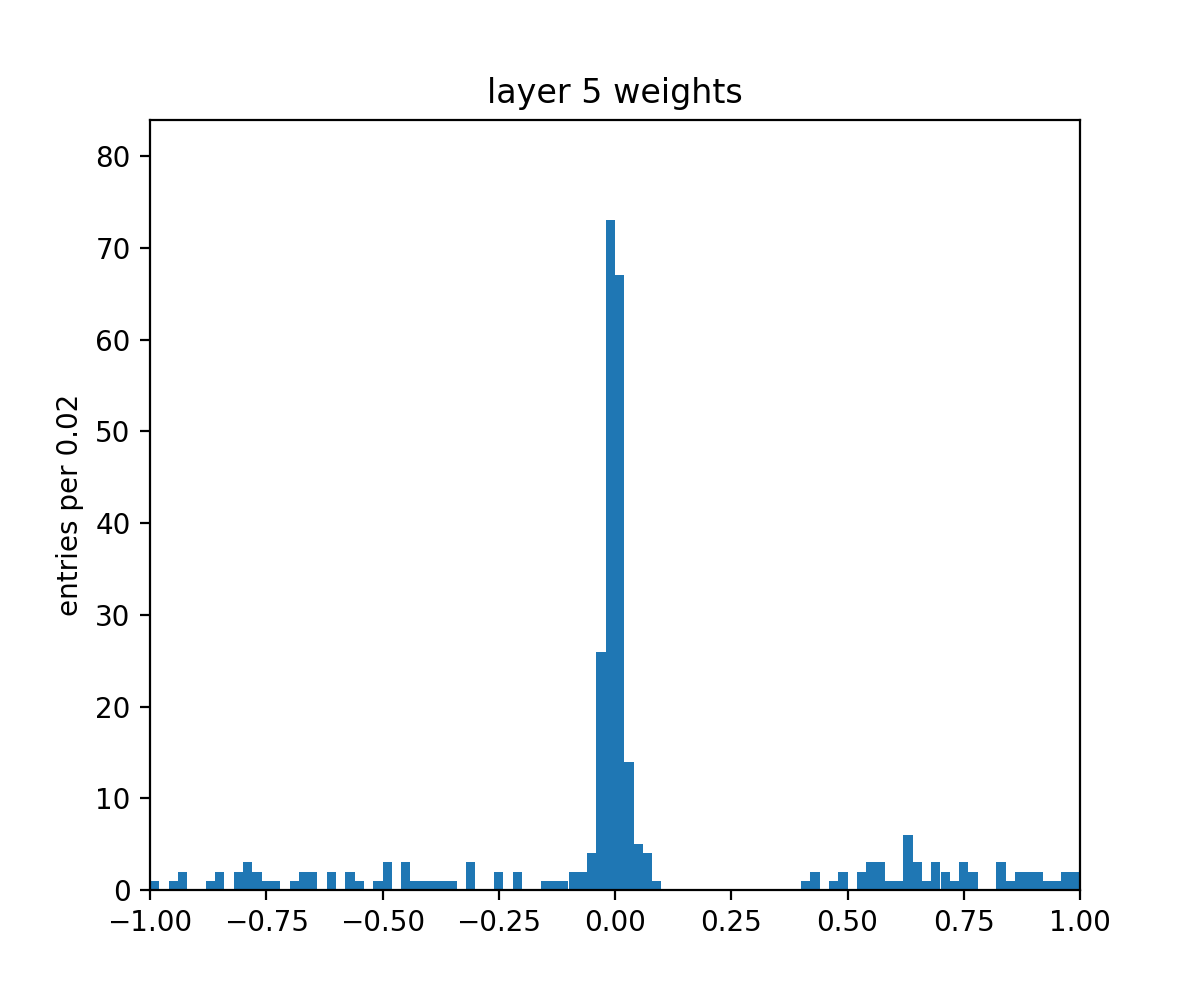

<IPython.core.display.Javascript object>


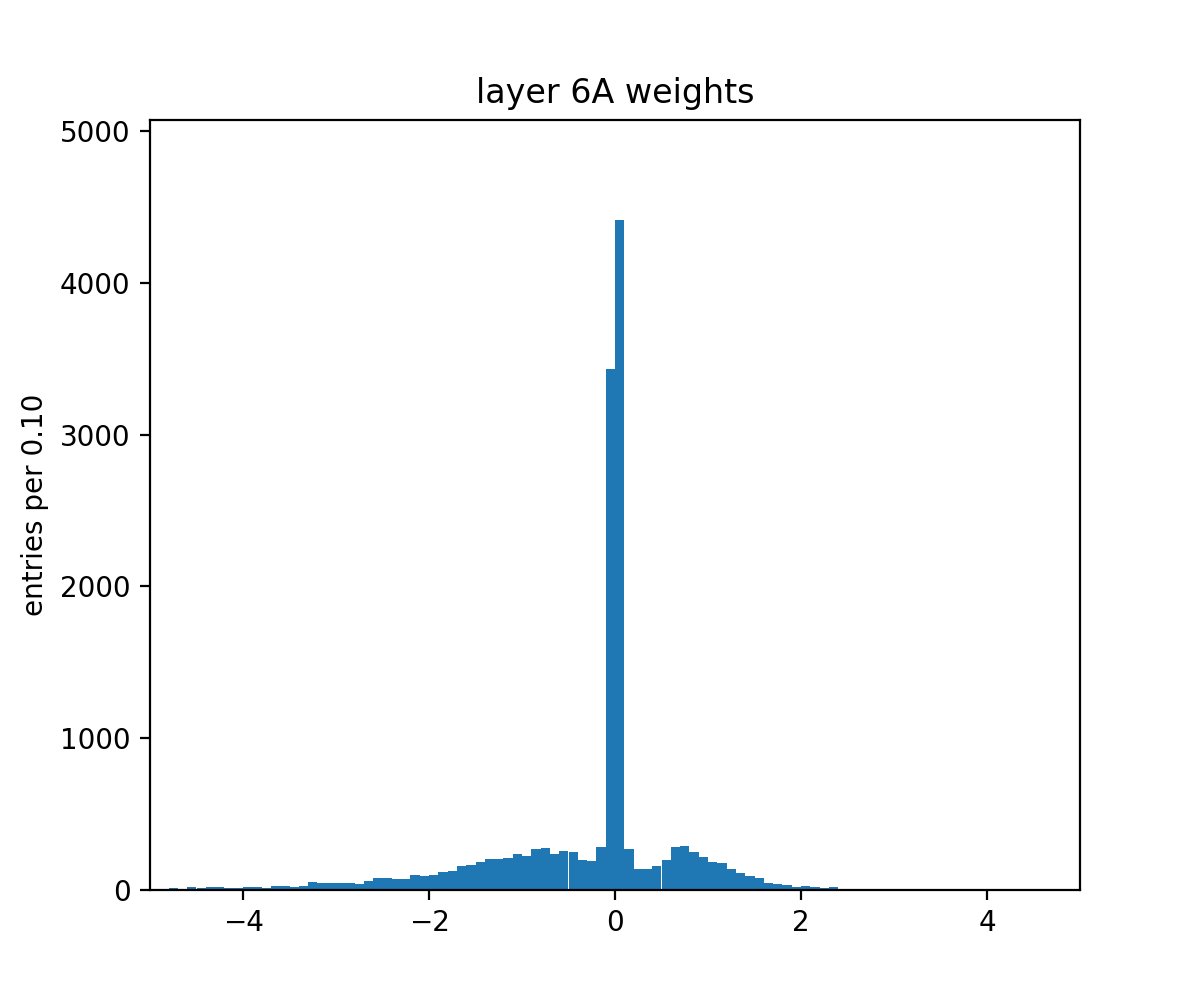

<IPython.core.display.Javascript object>


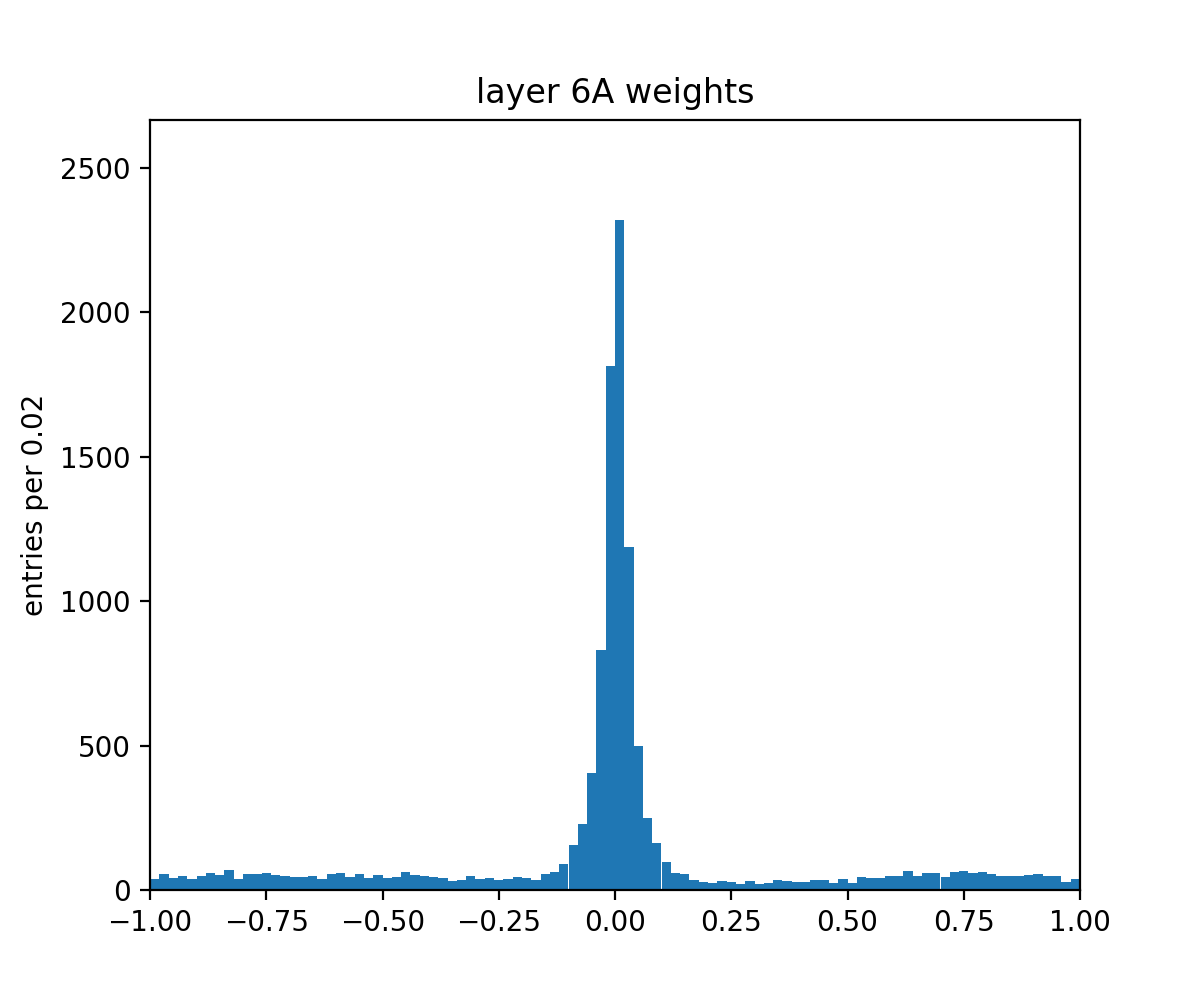

In [18]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size


print('model = ',model)
print('model.layer1.weight.shape = ',model.layer1.weight.shape)
weights = model.layer1.weight.flatten()
weights = weights.cpu()
weights = weights.detach().numpy()


plt.figure()
plt.title('layer 1 weights')
nC, bins, patches = plt.hist(weights,bins=100,range=(-5.,5.))
plt.ylabel('entries per 0.10')
plt.axis([-5.,5.,0.,1.15*max(nC)])
plt.show()


plt.figure()
plt.title('layer 1 weights')
nC, bins, patches = plt.hist(weights,bins=100,range=(-1.,1.))
plt.ylabel('entries per 0.02')
plt.axis([-1.,1.,0.,1.15*max(nC)])
plt.show()

######## ---------

weights = model.layer2.weight.flatten()
weights = weights.cpu()
weights = weights.detach().numpy()


plt.figure()
plt.title('layer 2 weights')
nC, bins, patches = plt.hist(weights,bins=100,range=(-5.,5.))
plt.ylabel('entries per 0.10')
plt.axis([-5.,5.,0.,1.15*max(nC)])
plt.show()


plt.figure()
plt.title('layer 2 weights')
nC, bins, patches = plt.hist(weights,bins=100,range=(-1.,1.))
plt.ylabel('entries per 0.02')
plt.axis([-1.,1.,0.,1.15*max(nC)])
plt.show()

### ------------

weights = model.layer3.weight.flatten()
weights = weights.cpu()
weights = weights.detach().numpy()


plt.figure()
plt.title('layer 3 weights')
nC, bins, patches = plt.hist(weights,bins=100,range=(-5.,5.))
plt.ylabel('entries per 0.10')
plt.axis([-5.,5.,0.,1.15*max(nC)])
plt.show()


plt.figure()
plt.title('layer 3 weights')
nC, bins, patches = plt.hist(weights,bins=100,range=(-1.,1.))
plt.ylabel('entries per 0.02')
plt.axis([-1.,1.,0.,1.15*max(nC)])
plt.show()

######## ---------

weights = model.layer4.weight.flatten()
weights = weights.cpu()
weights = weights.detach().numpy()


plt.figure()
plt.title('layer 4 weights')
nC, bins, patches = plt.hist(weights,bins=100,range=(-5.,5.))
plt.ylabel('entries per 0.10')
plt.axis([-5.,5.,0.,1.15*max(nC)])
plt.show()


plt.figure()
plt.title('layer 4 weights')
nC, bins, patches = plt.hist(weights,bins=100,range=(-1.,1.))
plt.ylabel('entries per 0.02')
plt.axis([-1.,1.,0.,1.15*max(nC)])
plt.show()

############## !!!!!!!!!!!!


weights = model.layer5.weight.flatten()
weights = weights.cpu()
weights = weights.detach().numpy()


plt.figure()
plt.title('layer 5 weights')
nC, bins, patches = plt.hist(weights,bins=100,range=(-5.,5.))
plt.ylabel('entries per 0.10')
plt.axis([-5.,5.,0.,1.15*max(nC)])
plt.show()


plt.figure()
plt.title('layer 5 weights')
nC, bins, patches = plt.hist(weights,bins=100,range=(-1.,1.))
plt.ylabel('entries per 0.02')
plt.axis([-1.,1.,0.,1.15*max(nC)])
plt.show()

######## ---------

weights = model.layer6A.weight.flatten()
weights = weights.cpu()
weights = weights.detach().numpy()


plt.figure()
plt.title('layer 6A weights')
nC, bins, patches = plt.hist(weights,bins=100,range=(-5.,5.))
plt.ylabel('entries per 0.10')
plt.axis([-5.,5.,0.,1.15*max(nC)])
plt.show()


plt.figure()
plt.title('layer 6A weights')
nC, bins, patches = plt.hist(weights,bins=100,range=(-1.,1.))
plt.ylabel('entries per 0.02')
plt.axis([-1.,1.,0.,1.15*max(nC)])
plt.show()




FC weights plotted above look like they have been pruned and regrown -- amny are near zero, but no longer equal to zero.

<IPython.core.display.Javascript object>


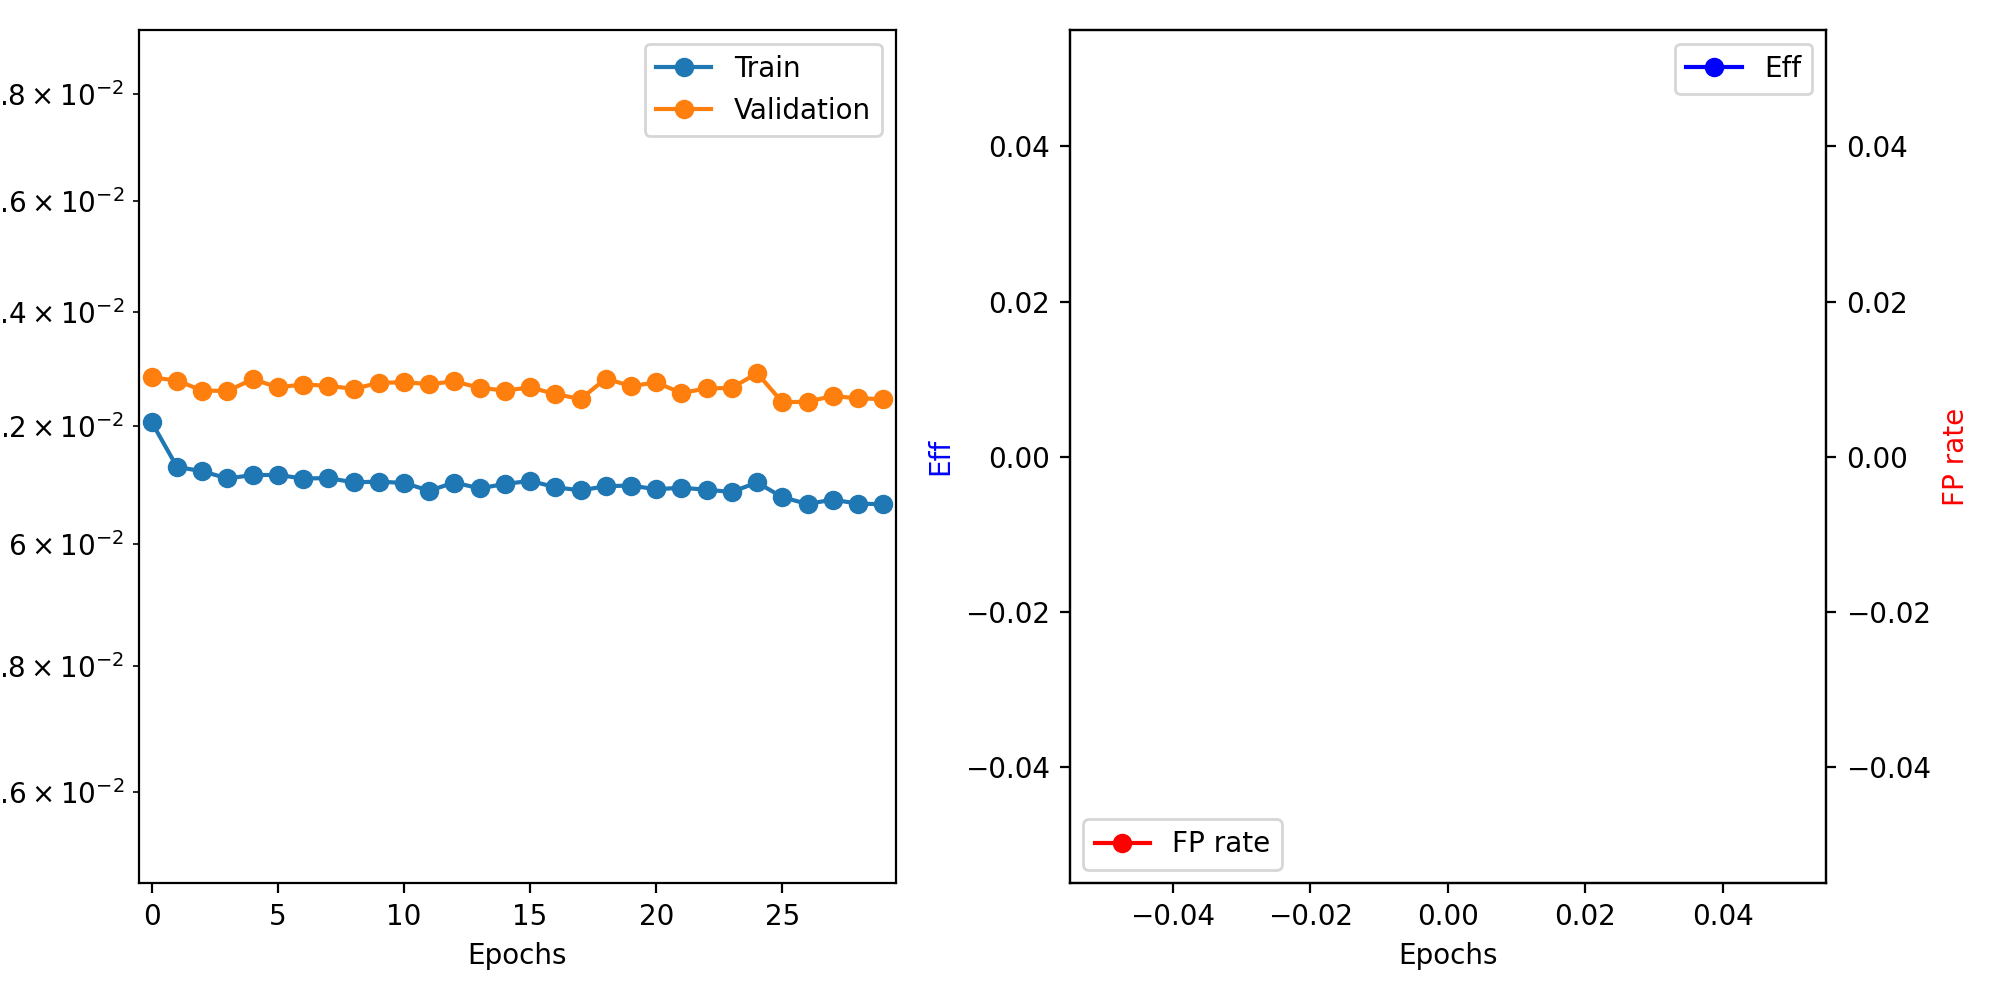

In [19]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

In [20]:
for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        n_epochs, epoch_start=len(results),
                        notebook=True):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    xs = results.index
    
    # Update the plot above
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)

    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')

Number of batches: train = 4012, val = 884
Number of batches: train = 4012, val = 884
Epoch 0: train=0.0620638, val=0.0628449, took 94.599 s
Epoch 1: train=0.0613002, val=0.0627893, took 91.887 s
Epoch 2: train=0.0612275, val=0.0626154, took 87.616 s
Epoch 3: train=0.0611045, val=0.0626071, took 84.642 s
Epoch 4: train=0.0611626, val=0.0628128, took 81.734 s
Epoch 5: train=0.0611642, val=0.0626724, took 79.949 s
Epoch 6: train=0.0611035, val=0.0627203, took 80.181 s
Epoch 7: train=0.0611112, val=0.0626977, took 78.655 s
Epoch 8: train=0.0610388, val=0.0626449, took 78.552 s
Epoch 9: train=0.061051, val=0.0627473, took 78.588 s
Epoch 10: train=0.061028, val=0.0627607, took 79.958 s
Epoch 11: train=0.0608983, val=0.062727, took 76.943 s
Epoch 12: train=0.0610346, val=0.0627748, took 78.657 s
Epoch 13: train=0.0609365, val=0.062663, took 77.486 s
Epoch 14: train=0.0610114, val=0.0626156, took 79.486 s
Epoch 15: train=0.0610631, val=0.0626689, took 128.1 s
Epoch 16: train=0.0609567, val=0.

In [21]:

learning_rate = 4e-6
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [22]:
## to see what this does

for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        30, epoch_start=len(results),
                        notebook=True):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    xs = results.index
    
    # Update the plot above
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)

    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')

Number of batches: train = 4012, val = 884
Number of batches: train = 4012, val = 884
Epoch 25: train=0.0607874, val=0.0624135, took 88.611 s
Epoch 26: train=0.060673, val=0.06242, took 96.78 s
Epoch 27: train=0.060746, val=0.0625215, took 94.841 s
Epoch 28: train=0.0606784, val=0.0624791, took 97.205 s
Epoch 29: train=0.0606693, val=0.0624667, took 97.568 s


<IPython.core.display.Javascript object>


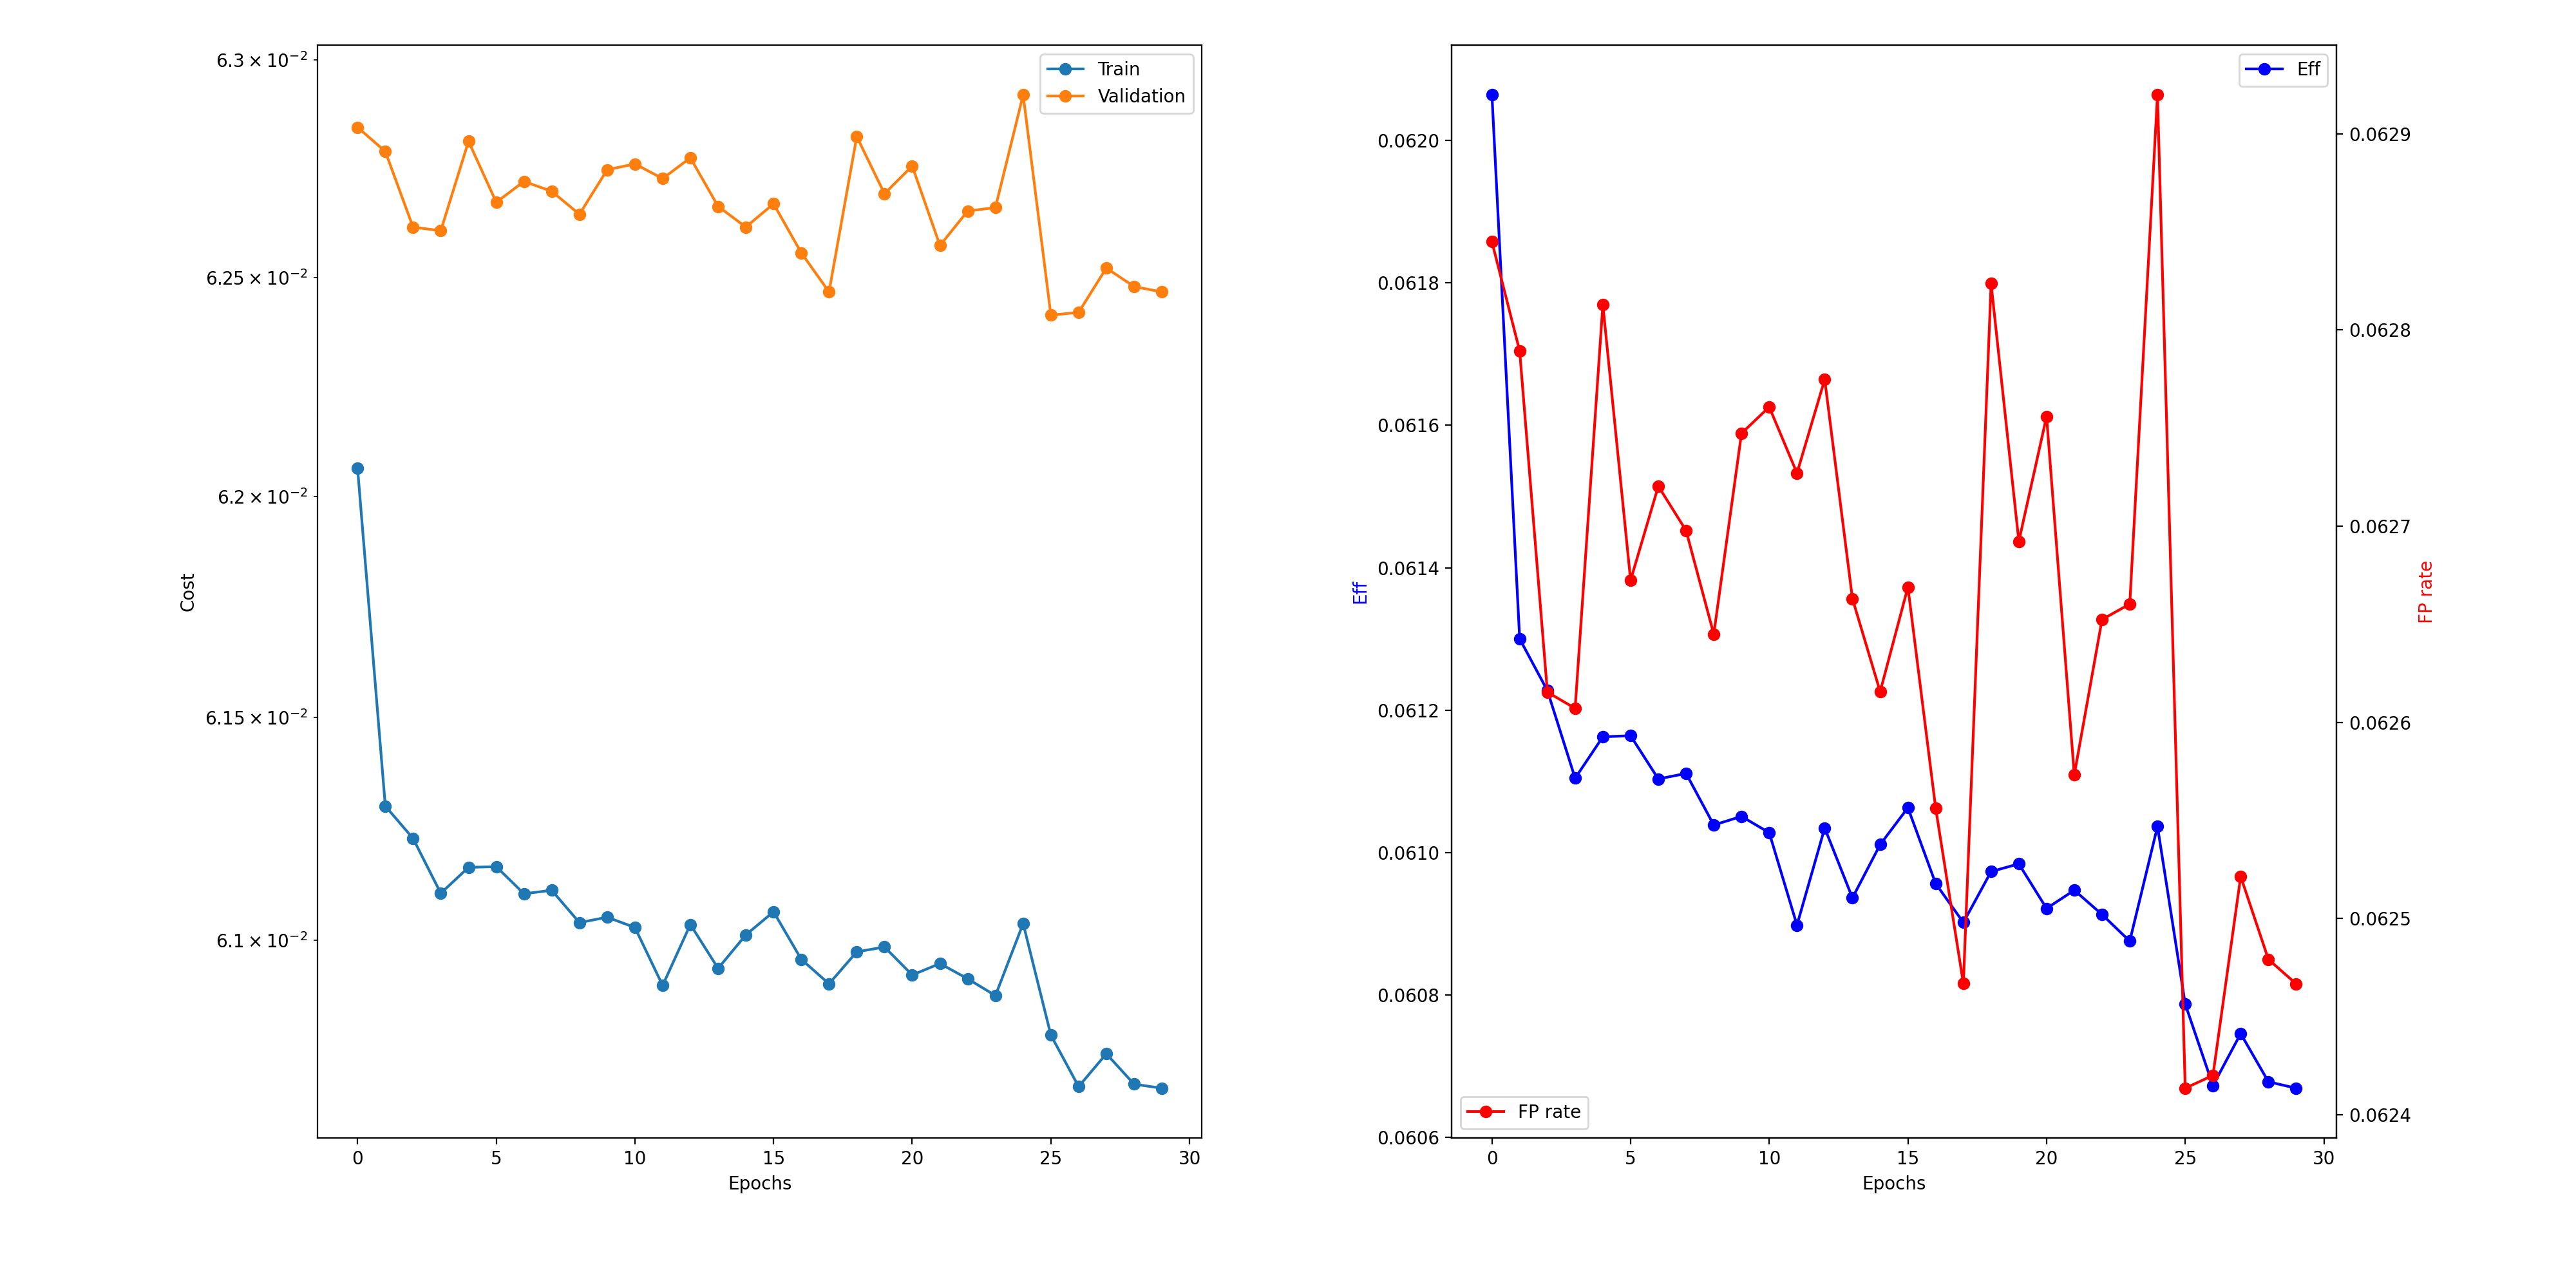

In [23]:
dual_train_plots(results.index,
                 results.cost, results.val,
                 results.cost, results.val)
plt.tight_layout()
plt.savefig(str(output / f'{name}_epoch_29.png'))

In [ ]:
for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        225, epoch_start=len(results),
                        notebook=True):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    xs = results.index
    
    # Update the plot above
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)

    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')

In [ ]:
dual_train_plots(results.index,
                 results.cost, results.val,
                 results.cost, results.val)
plt.tight_layout()
plt.savefig(str(output / f'{name}_epoch_04.png'))

It appears that the training cost has reached a new minimum, and the validation cost has touched a new minimum,
although its overalll behavior is consistent with fluctuations around the previous minimum.  

In any case, continue for another 200 epochs to see whether the training cost continues it march down.

In [ ]:
for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        425, epoch_start=len(results),
                        notebook=True):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    xs = results.index
    
    # Update the plot above
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)

    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')

In [ ]:
dual_train_plots(results.index,
                 results.cost, results.val,
                 results.cost, results.val)
plt.tight_layout()
plt.savefig(str(output / f'{name}_epoch_424.png'))

The training cost is falling slowly.  What will happen if the learning rate is reduced from 2e-5 to 4e-6?

In [ ]:
learning_rate = 4e-6
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [ ]:
## train for another 5 epochs with a lower learning rate
## to see what this does

for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        525, epoch_start=len(results),
                        notebook=True):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    xs = results.index
    
    # Update the plot above
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)

    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')

Let's look at the rcbn1[0] biases to see if whether those corresponding to the pruned weights are zero 

In [ ]:
dual_train_plots(results.index,
                 results.cost, results.val,
                 results.cost, results.val)
plt.tight_layout()
plt.savefig(str(output / f'{name}_epoch_524.png'))